# Introduction
Last week, you implemented a fully-connected neural network for image classification on the CIFAR10 Dataset and reached a test set accuracy of around ~0.5. This weeks task is to improve on that, by changing the model to a convolutional neural network that you'll build from scratch. Before starting on the programming exercise, we strongly recommend having watched the lecture and looked at the slides. All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

CAUTION: You need python version >= 3.4!



## Grading
For this programming exercise, there are 100 points in total.

**Required Exercises**

| Section| Part                                         |Submitted Function                           | Points 
|--------|:-                                            |:-                                           | :-:    
| 1      | [Implementing a Convolutional Neural Net](#convnet)                         |[`conv_forward_naive`](#conv_forward_naive)  | 15
|        |                                              |[`max_pool_forward_naive`](#max_pool_forward_naive)| 10
|        |                                              |[`conv_backward_naive`](#conv_backward_naive)| 15
|        |                                              |[`max_pool_backward_naive`](#max_pool_backward_naive)| 10
| 2      | [Three Layer Convolutional Neural Network](#ThreeLayerConvNet) | [`ThreeLayerConvNet`](#ThreeLayerConvNet)   | 15
| 3      | [Qualitative Analysis](#qualitative_analysis)|[q1](#qualitative_analysis_questions)        | 15
|        |                                              |[q2](#qualitative_analysis_questions)        | 20
|        | Total Points                                 |                                             | 100


## Image classification Benchmark CIFAR10
Here are some quick facts again:
The dataset consists of 50,000/10,000 training/test images (each in $32 \times 32$ resolution with RGB color channels). We further split the training images into 45,000 training samples and 5,000 validation samples. Each pixel is represented as three floating point numbers, indicating the color intensity in the respective color channel. Each image is labeled with integers ranging from 0 to 9 (0-9), indicating the class of the image content. The 10 classes and according example images from the dataset are shown in the image below. 

![Cifar10](https://pytorch.org/tutorials/_images/cifar10.png)

You can load the complete dataset into memory by just running the next cell. If you edited the function `get_CIFAR10_data` in exercise 3, then just reuse your code and copy it below. Dimension have to agree with:
```python
('X_train: ', (45000, 3, 32, 32))
('y_train: ', (45000,))
('X_val: ', (5000, 3, 32, 32))
('y_val: ', (5000,))
('X_test: ', (10000, 3, 32, 32))
('y_test: ', (10000,))
```

In [1]:
# Load CIFAR10 data
#Load utils
from utils import *
import os
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import numpy as np
# configure plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_CIFAR10_data(
    num_training=45000, num_validation=5000, num_test=10000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    (train, test) = cifar10.load_data()
    X_train, y_train = train
    X_train = X_train.astype(np.float32)
    X_test, y_test = test
    X_test = X_test.astype(np.float32)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": np.squeeze(y_train),
        "X_val": X_val,
        "y_val": np.squeeze(y_val),
        "X_test": X_test,
        "y_test": np.squeeze(y_test),
    }

# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

2024-05-16 11:01:43.566477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 11:01:44.407211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


('X_train: ', (45000, 3, 32, 32))
('y_train: ', (45000,))
('X_val: ', (5000, 3, 32, 32))
('y_val: ', (5000,))
('X_test: ', (10000, 3, 32, 32))
('y_test: ', (10000,))


# Convolutional Neural Nets
As we saw in the previous exercise, Fully-Connected Neural Networks receive an input (a single vector), and transform it through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores. 

These Nets don’t scale well to full images. In CIFAR-10, images are only of size 32x32x3 (32 width, 32 hight, 3 color channels), so a single fully-connected neuron in a first hidden layer of a regular Neural Network would have 32x32x3 = 3072 weights. This amount still seems manageable, but clearly this fully-connected structure does not scale to larger images. For example, an image of more respectable size, e.g. 200x200x3, would lead to neurons that have 200x200x3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly!

Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a FC Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. Note that the word depth here refers to the third dimension of an activation volume or the number of filters, not to the depth of a full Neural Network, which can refer to the total number of layers in a network. For example, the input images in CIFAR-10 are an input volume of activations, and the volume has dimensions 32x32x3 (width, height, depth respectively). As we will soon see, the neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner. Moreover, the final output layer for CIFAR-10 would have dimensions 1x1x10, because by the end of the ConvNet architecture, we will reduce the full image into a single vector of class scores, arranged along the depth dimension. 

## Layers used to build CNNs
A ConvNet can be seen as a sequence of layers, and every layer of it transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (the ones you built in exercise 3). We will stack these layers to form a full ConvNet architecture. In this tutorial the architecture will be as follows:

- INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
- CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.
- RELU layer will apply an elementwise activation function, such as the max(0,x)
thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
- POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
- FC layers: these are just the fully connected layers you implemented in exercise 3. They flatten the input from 3D to 2D and then to affine transformations and activations. 
![CNN](https://i.imgur.com/1agcV6t.png)

## Convolutional Layer

The Conv layer is the core building block of a Convolutional Network that does most of the computational heavy lifting.

The CONV layer consist of a set of learnable filters. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. For example, a typical filter on a first layer of a ConvNet might have size 5x5x3 (i.e. 5 pixels width and height, and 3 because images have depth 3, the color channels). During the forward pass, we slide (more precisely, convolve) each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or eventually entire honeycomb or wheel-like patterns on higher layers of the network. Now, we will have an entire set of filters in each CONV layer (e.g. 12 filters), and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension and produce the output volume.

*Local Connectivity*. When dealing with high-dimensional inputs such as images, as we saw above, it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyperparameter called the receptive field of the neuron (equivalently this is the filter size). The extent of the connectivity along the depth axis is always equal to the depth of the input volume. It is important to emphasize again this asymmetry in how we treat the spatial dimensions (width and height) and the depth dimension: The connections are local in space (along width and height), but always full along the entire depth of the input volume.

*Example 1*. For example, suppose that the input volume has size [32x32x3], (e.g. an RGB CIFAR-10 image). If the receptive field (or the filter size) is 5x5, then each neuron in the Conv Layer will have weights to a [5x5x3] region in the input volume, for a total of 5x5x3 = 75 weights (and +1 bias parameter). Notice that the extent of the connectivity along the depth axis must be 3, since this is the depth of the input volume.

*Example 2*. Suppose an input volume had size [16x16x20]. Then using an example receptive field size of 3x3, every neuron in the Conv Layer would now have a total of 3x3x20 = 180 connections to the input volume +1 for the bias. Notice that, again, the connectivity is local in space (e.g. 3x3), but full along the input depth (20).

## The following three hyperparameters control the output dimensions of a Conv Layer

### Stride
Stride denotes the 'stepsize' that the convolution operation uses to 'slide' the kernel over the input. Depending on the size of the stride, the size of the output volume differs. Using a stride 1 on a 7×7 input will lead to an output volume of size $5 \times 5$. Whereas a stride of 2 applied on the same image will lead to an output volume of the size $3\times 3$. The example below visualizes the difference. Note: The stride is constrained to integers that will lead to valid output volumes. In the example below a stride of 3 is invalid, since there won't be only valid dot products in the formulation. 
![Stride](https://i.imgur.com/CRTziQV.png)

### Zero Padding
As mentioned earlier, applying filters shrinks the height and width of the input image. Using padding is a possibility to maintain the size of the input volume when applying a filter to it. Zero-Padding adds zeros around the border of the input image. That way you can build deeper networks because your image won’t shrink when applying many layers and it is easier to match dimensions for other operations such as concatenations.It’s pretty straight forward to calculate the padding which you have to add to prevent the volumes from shrinking: $p=(f−1)/ 2$ with $f$ being the size of the filter-kernel. In the example below the filter-kernel has size $3\times 3$, so a padding of $(3-1)/2=1$ at each spatial dimension of the input image will preserve it's spatial dimensions.  Additionally, more information from the pixels at the borders of the image will be used, since the filter will slide over it more than once. By the way, numpy offers the really convenient `np.pad()` function :)
![Padding](https://i.imgur.com/ZyLyf7P.png)

### Number of filters
Each filter returns a single filter-map, therefore the number of fiters in a layer determine the depth dimension of the volume that gets passed on in the network.

Example 3. Suppose an input volume had size $[16\times 16 \times 20]$ and a Conv Layer with 10 (alternatively 30) filters with kernel-size $3\times 3$ and zero-padding of 1 (so spatial dimensions are preserved. Then the output volume will have dimensions $[16\times 16 \times 10]$ (alternatively $[16\times 16 \times 30]$).


<a id="convnet"></a>
# 1. Implementing a Convolutional Neural Net

In this exercise we want to implment a three layered convolutional neural network using a convolution layer with activation and max pooling. 

## 1.1 Forward pass

Before you dive in make sure you understand the topic. Following sources might help you with that:
- [Stanford cs231n Webpage about Convolutional Neural Networks](https://cs231n.github.io/convolutional-networks/)
- [A blog post on Convolutions from different theoretical perspectives](https://timdettmers.com/2015/03/26/convolution-deep-learning/)


## 1.1.1 Convolution Layer: forward

Now please implement the function `conv_forward_naive` below, which calculates pre-activations $z^{(l)} = w^{(l-1)}*x + b^{(l-1)}$  and test your implementation with the provided test cases.

Hint: Pad the input and then loop over all `N` samples in the batch, and over all Filters `F`, and over all spatial dimensions in `H_prime` and `W_prime` direction with step size `conv_param['stride']` to get the sub-regions of the image and calculate the dot products of the filter kernels and add the bias. Store the resulting values in the according spot in the output volume. 

<a id="conv_forward_naive"></a>

In [2]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.
    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.
    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 
        
    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.
    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x_pad, w, b, conv_param)
    """
    out = None
    # Extract shapes and constants
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param.get('stride', 1)
    pad = conv_param.get('pad', 0)
    # Check for parameter sanity
    assert (H + 2 * pad - HH) % stride == 0, 'Sanity Check Status: Conv Layer Failed in Height'
    assert (W + 2 * pad - WW) % stride == 0, 'Sanity Check Status: Conv Layer Failed in Width'
    # Construct output placeholder
    H_prime = 1 + (H + 2 * pad - HH) // stride
    W_prime = 1 + (W + 2 * pad - WW) // stride
    out = np.zeros((N, F, H_prime, W_prime))
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x_pad = np.pad(x, ((0,0), (0,0), (pad,pad), (pad,pad)), 'constant')

    for n in range(N):
        for f in range(F):
            for i in range(H_prime):
                for j in range(W_prime):
                    window = x_pad[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW]
                    output = np.sum(window * w[f, :]) + b[f]
                    out[n, f, i, j] = output

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x_pad, w, b, conv_param)
    return out, cache


In [3]:
# Test the conv_forward_naive function

x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


### 1.1.2 Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.


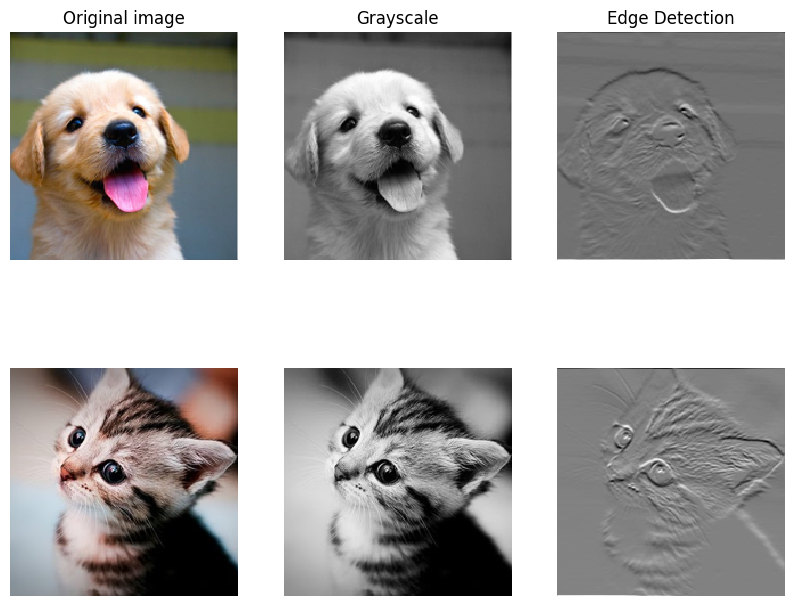

In [4]:
from PIL import Image  # run "pip install pillow" if you get an import error
import requests
from io import BytesIO

def read_img_from_url(url):
    response = requests.get(url)
    print(response)
    return Image.open(BytesIO(response.content))

kitten = read_img_from_url('https://i.imgur.com/tWRmyaa.jpeg')
puppy = read_img_from_url('https://i.imgur.com/Ib1WRcw.jpeg')

# the above didn't work for me so i downloaded the images locally
# kitten = Image.open('tWRmyaa.jpeg')
# puppy = Image.open('Ib1WRcw.jpeg')

# kitten is wide, and puppy is already square
d = kitten.size[1] - kitten.size[0]
kitten = kitten.crop([-d//2,0,kitten.size[0]+d//2,kitten.size[1]])

img_size = 200   # Make this smaller if it runs too slow
puppy = np.array(puppy.resize((img_size, img_size)))
kitten = np.array(kitten.resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = puppy.transpose((2, 0, 1))
x[1, :, :, :] = kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True, cmap=None):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'), cmap=cmap)
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0],cmap='gray')
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1],cmap='gray')
plt.title('Edge Detection')
plt.subplot(2, 3, 4)
imshow_noax(kitten, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0],cmap='gray')
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1],cmap='gray')
plt.show()

## 1.1.3 Max-Pooling Layer: forward
This layer applies the max function to sub regions of the input volume. These sub regions do usually not overlap. The max function takes the maximum value of each of the regions and copys it into the output volume, which has it's spatial dimensions reduced according to the size of the subregion. In the following example, the pooling layer is applied on 2x2 subregions of the input volume, reducing the width and height by 1/2 (or the resolution by 1/4) of its original size while the depth stays the same. For the upper left subregion, the max pooling function is calculated as follows: $p_{(1,1)} = max(a_{(1,1)},a_{(1,2)},a_{(2,1)},a_{(2,2)}) = max(3,5,7,9) = 9$. Hint: This can also be implemented like the nested loop for the convolution: a filter of size $2\times 2$ with stride $2$ is used and it returns the maximum value for each subregion it slides over. 
![Max Pooling](https://i.imgur.com/ccxu58n.png)

Now please implement the function `max_pool_forward_naive` below, which downsamples the image and test your implementation with the provided test cases.

<a id="max_pool_forward_naive"></a>

In [5]:
def max_pool_forward_naive(x, pool_param):
    """
    A naive implementation of the forward pass for a max-pooling layer.
    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions
    No padding is necessary here. Output size is given by 
    Returns a tuple of:
    - out: Output data, of shape (N, C, H', W') where H' and W' are given by
      H' = 1 + (H - pool_height) / stride
      W' = 1 + (W - pool_width) / stride
    - cache: (x, pool_param)
    """
    # Extract shapes and constants
    out = None
    N, C, H, W = x.shape
    HH = pool_param.get('pool_height', 2)
    WW = pool_param.get('pool_width', 2)
    stride = pool_param.get('stride', 2)
    assert (H - HH) % stride == 0, 'Sanity Check Status: Max Pool Failed in Height'
    assert (W - WW) % stride == 0, 'Sanity Check Status: Max Pool Failed in Width'
    # Construct output placeholder
    H_prime = 1 + (H - HH) // stride
    W_prime = 1 + (W - WW) // stride
    out = np.zeros((N, C, H_prime, W_prime))
    ###########################################################################
    # TODO: Implement the max-pooling forward pass                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    for n in range(N):
        for c in range(C):
            for i in range(H_prime):
                for j in range(W_prime):
                    window = x[n, c, i*stride:i*stride+HH, j*stride:j*stride+WW]
                    output = np.max(window)
                    out[n, c, i, j] = output

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, pool_param)

    return out, cache


In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


## 1.2 Backward pass
Last week you implemented the backpropagation of errors algorithm for affine layers and the ReLU activation function. Furthermore, in the pen&paper exercise, you explored what will happen to the gradient of a weight, when a weight is shared among inputs (Hint: the multivariable chain-rule applies). Below you see a simplified example of a single dot product in a convolution operation. Since our input $a^{(l-1)}$ has no depth dimension, only height $h$ and width $w$, the weight matrix of filter $j$ neither has depth. The filter size is $2\times2$ and the dot product plus bias with the upper left corner of the input is computed as $z_{j,(1,1)}^{(l)} = w^{(l-1)}_{j} \cdot a^{(l-1)}_{(1:2,1:2)} + b_j$. Then the ReLU activation function $a_{j,(1,1)}^{(l)} = max(0,z_{j,(1,1)}^{(l)})$ is applied. After the convolution and activation, the max-pooling operation is applied on a $2\times 2$ subregion of the activation map $a_{j,(1:2,1:2)}^{(l)}$.
![Conv Backprop](https://i.imgur.com/cfSzpXc.png)

### 1.2.1 Convolution Layer: backward

Again, this functions gets the output from `relu_backward` $\frac{\partial L_\theta}{\partial z^{(l)}}$ as the input, together with the cached variables from the forward pass $a^{(l-1)}$, $w^{(l-1)}$ and $b^{(l-1)}$ and the dict `conv_params`. It computes the derivatives `dw`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial w^{(l-1)}}$, `db`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial b^{(l-1)}}$ and `dx`$=\frac{\partial L_\theta}{\partial z^{(l)}} \frac{\partial z^{(l)}}{\partial a^{(l-1)}}$. All of these derivatives are the same as in last weeks exercise, the only difference is that we need the multivariable chain rule to calculate them because $z^{(l)}= w^{(l-1)}*a^{(l-1)} + b^{(l-1)}$ is the result of a convolution instead of a dot product $z^{(l)}= w^{(l-1)} a^{(l-1)} + b^{(l-1)}$ as in last weeks exercise.

Now implement the `conv_backward_naive` function and test your implementation using numeric gradient checking.

Implementation: loop again over all samples `N`, all filters `F`, and all image directions `H_prime` and `W_prime'` and sum the gradients from all respective regions where the filter was applied. 
<a id="conv_backward_naive"></a>

In [7]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.
    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x_pad, w, b, conv_param) as in conv_forward_naive
    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    # Extract shapes and constants
    x_pad, w, b, conv_param = cache
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride = conv_param.get('stride', 1)
    pad = conv_param.get('pad', 0)
    # Construct output placeholders
    H_prime = 1 + (H + 2 * pad - HH) // stride
    W_prime = 1 + (W + 2 * pad - WW) // stride
    dx = np.zeros_like(x_pad)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)

    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    # Hint: dx needs to have the same shape as x                              #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    for n in range(N):
        for f in range(F):
            for i in range(H_prime):
                for j in range(W_prime):
                    dx[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW] += w[f, :] * dout[n, f, i, j]
                    dw[f, :] += x_pad[n, :, i*stride:i*stride+HH, j*stride:j*stride+WW] * dout[n, f, i, j]
                    db[f] += dout[n, f, i, j]

    dx = dx[:, :, pad:pad+H, pad:pad+W]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [8]:
# Test the conv_backward_naive function
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.37264006649648e-11


### 1.2.2 Max-Pooling: backward

You already saw in the forward pass, that the max-pooling operation can be impemented kind of like the convolution. The same applies to the gradient calculation. The gradient of the pooling function with respect to a single activation for a $2\times 2$ pooling subregion is just $\frac{p_{(1,1)}}{a_{(1,1)}} = \begin{cases}
1 \text{, if } a_{(1,1)}>a_{(1,2)},a_{(2,1)},a_{(2,2)}\\
0 \text{, else }\\
\end{cases}$.
Therefore the upstream derivative just gets multiplied by $1$ for the max location and by $0$ for all other locations. One possibility to solve this, is by following these steps:
- loop again over all samples `N`, all channels `C`, and all image directions `H_prime'` and `W_prime'` and find the index of the maximum element in `x` and store the according value of `dout` in that location in `dx`.

<a id="max_pool_backward_naive"></a>

In [9]:
def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max-pooling layer.
    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.
    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    # Extract constants and shapes
    x, pool_param = cache
    N, C, H, W = x.shape
    HH = pool_param.get('pool_height', 2)
    WW = pool_param.get('pool_width', 2)
    stride = pool_param.get('stride', 2)
    H_prime = 1 + (H - HH) // stride
    W_prime = 1 + (W - WW) // stride
    # Construct output placeholder
    dx = np.zeros_like(x)
    ###########################################################################
    # TODO: Implement the max-pooling backward pass                           #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    for n in range(N):
        for c in range(C):
            for i in range(H_prime):
                for j in range(W_prime):
                    window = x[n, c, i*stride:i*stride+HH, j*stride:j*stride+WW]
                    mask = window == np.max(window)
                    dx[n, c, i*stride:i*stride+HH, j*stride:j*stride+WW] += mask * dout[n, c, i, j]

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [10]:
# Test the max_pool_backward_naive function
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


## 1.3 Fast layers
Below we provide a more sophisticated implementation of the above implemented convolution and max-pooling layers. They will decrease runtime for the following tasks and also allow students who didn't finish the tasks above to continue with the next exercises. If you want to know more about increasing efficiency of convolution operations, [here](https://sahnimanas.github.io/post/anatomy-of-a-high-performance-convolution/) is a neat ressource.

In [11]:
from fast_layers import * 

### 1.3.1 Convenience layers
There are some common patterns of layers that are frequently used in neural nets. For example, conv layers are frequently followed by a ReLU nonlinearity and max pooling. To make these common patterns easy, we define convenience layers in the following. The convenience layers from exercise 3 are copied here too, because you need them for the implementation of the CNN.

In [12]:
def conv_relu_pool_forward(x, w, b, conv_param, pool_param):
    """
    Convenience layer that performs an convolution, followed by a ReLU and max pool

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    z, conv_cache = conv_forward_fast(x, w, b, conv_param)
    a, relu_cache = relu_forward(z)
    out, pool_cache = max_pool_forward_fast(a, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache


def conv_relu_pool_backward(dout, cache):
    """
    Backward pass for the conv-relu-max pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    da = max_pool_backward_fast(dout, pool_cache)
    dz = relu_backward(da, relu_cache)
    dx, dw, db = conv_backward_fast(dz, conv_cache)
    return dx, dw, db

def affine_relu_forward(x, w, b):
    """
    Convenience layer that performs an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

# 2. Three Layer Convolutional Neural Network
In the next step, you'll assemble all of the above into a small Convolutional Neural Network. The input images are passed into a `conv_relu_pool_forward` layer and then an `affine_relu_forward` layer and another `affine_forward` layer. Then the `cross_entropy_loss` is applied on the predictions, which calculates the softmax scores inside, so you don't have to take care about that.
Then you implement the backward pass via `affine_backward`, `affine_relu_backward` and `conv_relu_pool_backward`. The network structure should resemble the one in the image below. You don't have to care about flattening the activation volumes, since your `affine_forward` layer already takes care of this.

![CNN](https://i.imgur.com/1agcV6t.png)
<a id ="ThreeLayerConvNet"></a> 

In [13]:
class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:
    conv - relu - 2x2 max pool - affine - relu - affine - softmax
    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
                 hidden_dim=100, num_classes=10, weight_scale=1e-3,
                 dtype=np.float32):
        """
        Initialize a new network.
        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Width/height of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.dtype = dtype
        # initialize weights and biases
        C, H, W = input_dim
        HP, WP = 1 + (H - 2)//2, 1 + (W - 2)//2  # max pooling
        self.params['W1'] = weight_scale * np.random.randn(num_filters, C, filter_size, filter_size)
        self.params['b1'] = np.zeros(num_filters)
        self.params['W2'] = weight_scale * np.random.randn(num_filters*HP*WP, hidden_dim)
        self.params['b2'] = np.zeros(hidden_dim)
        self.params['W3'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b3'] = np.zeros(num_classes)

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.
        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # pass conv_param to the forward pass for the convolutional layer
        # Padding and stride chosen to preserve the input spatial size
        filter_size = W1.shape[2]
        conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the three-layer convolutional net,  #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        #                                                                          #
        # Remember you can use the functions defined in cs231n/fast_layers.py and  #
        # cs231n/layer_utils.py in your implementation (already imported).         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out1, cache1 = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
        out2, cache2 = affine_relu_forward(out1, W2, b2)
        scores, cache3 = affine_forward(out2, W3, b3)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}

        loss, softmax_grad = cross_entropy_loss(scores, y)
        ############################################################################
        # TODO: Implement the backward pass for the three-layer convolutional net, #
        # storing the gradients in the grads variables. Make sure that grads[k]    #
        # holds the gradients for self.params[k].                                  #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests.                                                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # backpropagation of gradients

        dx3, dW3, db3 = affine_backward(softmax_grad, cache3)
        dx2, dW2, db2 = affine_relu_backward(dx3, cache2)
        dx1, dW1, db1 = conv_relu_pool_backward(dx2, cache1)

        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2
        grads['W3'] = dW3
        grads['b3'] = db3

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [14]:
model = ThreeLayerConvNet()

# check forward pass
N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

# check gradients
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

print('Correct implementations may still have relative errors up to the order of e-2.')

Initial loss (no regularization):  2.3025837054551515
W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10
Correct implementations may still have relative errors up to the order of e-2.


## 2.1 Overfit small data

A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy. This is just a test, to see if the network has problems fitting the training data.


In [15]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)

In [16]:
#### DO NOT EDIT THIS CELL ####
solver.train()
#### DO NOT EDIT THIS CELL ####

(Iteration 1 / 60) loss: 2.414055
(Epoch 0 / 30) train acc: 0.140000; val_acc: 0.083800
(Iteration 2 / 60) loss: 2.388312
(Epoch 1 / 30) train acc: 0.130000; val_acc: 0.079400
(Iteration 3 / 60) loss: 2.286343
(Iteration 4 / 60) loss: 2.281295
(Epoch 2 / 30) train acc: 0.190000; val_acc: 0.094200
(Iteration 5 / 60) loss: 2.156608
(Iteration 6 / 60) loss: 2.121351
(Epoch 3 / 30) train acc: 0.220000; val_acc: 0.100000
(Iteration 7 / 60) loss: 2.082593
(Iteration 8 / 60) loss: 2.132932
(Epoch 4 / 30) train acc: 0.240000; val_acc: 0.101200
(Iteration 9 / 60) loss: 1.974939
(Iteration 10 / 60) loss: 2.235030
(Epoch 5 / 30) train acc: 0.270000; val_acc: 0.113800
(Iteration 11 / 60) loss: 2.062123
(Iteration 12 / 60) loss: 1.968403
(Epoch 6 / 30) train acc: 0.270000; val_acc: 0.115200
(Iteration 13 / 60) loss: 2.150977
(Iteration 14 / 60) loss: 1.962919
(Epoch 7 / 30) train acc: 0.330000; val_acc: 0.125600
(Iteration 15 / 60) loss: 1.906664
(Iteration 16 / 60) loss: 1.982907
(Epoch 8 / 30) tr

## 2.2 Train the network on the full dataset
This will take some time.. around 30-45 minutes. Make a short break and then continue. If you are using colab, please keep in mind that **colab resets your session after 30 mins of being idle.**

In [17]:
# Set hyperparameters
lr = 1e-3
hidden_dim = 100
epochs = 5
# build the network
model = ThreeLayerConvNet(weight_scale=1e-2,num_filters=32, hidden_dim=50)
# optimize
solver = Solver(model, data,
                num_epochs=epochs, batch_size=100,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=10)

In [18]:
#### DO NOT EDIT THIS CELL ####
solver.train()  
solver.save_params("three_layer_conv_net.pkl")  # please hand in this file as well!
#### DO NOT EDIT THIS CELL ####

(Iteration 1 / 2250) loss: 2.403988
(Epoch 0 / 5) train acc: 0.122000; val_acc: 0.111800
(Iteration 11 / 2250) loss: 2.287671
(Iteration 21 / 2250) loss: 2.255068
(Iteration 31 / 2250) loss: 2.168725
(Iteration 41 / 2250) loss: 2.058820
(Iteration 51 / 2250) loss: 2.100723
(Iteration 61 / 2250) loss: 2.057296
(Iteration 71 / 2250) loss: 1.987113
(Iteration 81 / 2250) loss: 1.987538
(Iteration 91 / 2250) loss: 1.926831
(Iteration 101 / 2250) loss: 1.788114
(Iteration 111 / 2250) loss: 1.884939
(Iteration 121 / 2250) loss: 1.840494
(Iteration 131 / 2250) loss: 1.871836
(Iteration 141 / 2250) loss: 1.795279
(Iteration 151 / 2250) loss: 1.885542
(Iteration 161 / 2250) loss: 1.942629
(Iteration 171 / 2250) loss: 1.788146
(Iteration 181 / 2250) loss: 1.837454
(Iteration 191 / 2250) loss: 1.822811
(Iteration 201 / 2250) loss: 1.688227
(Iteration 211 / 2250) loss: 1.758322
(Iteration 221 / 2250) loss: 1.717441
(Iteration 231 / 2250) loss: 1.794797
(Iteration 241 / 2250) loss: 1.659963
(Iterati

#########################################
Overall Accuracy on the test set:  0.5502
#########################################


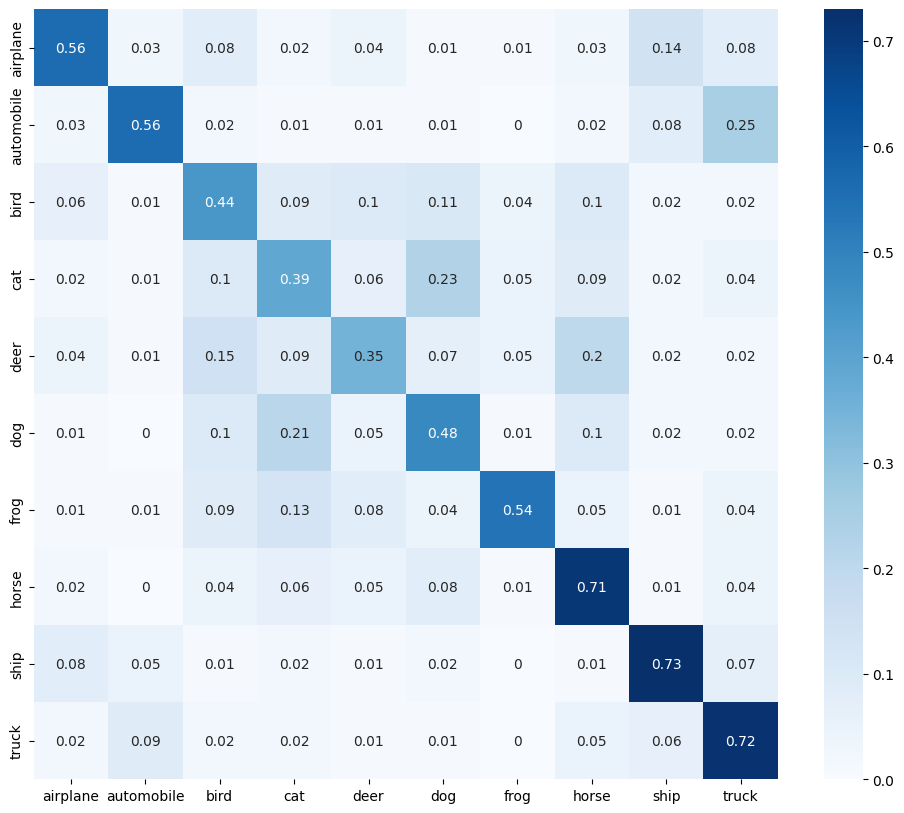

In [19]:
#@title Test set results
#@markdown Visualization of the confusion matrix. On the vertical axis are the real labels,
#@markdown on the horizontal axis are the predicted labels. 
#@markdown The overall accuracy of the model should be around ~0.57.

acc, pred = solver.check_accuracy(data['X_test'], data['y_test'], num_samples=10000)
y_pred = pred['y_pred']
print('#########################################')
print('Overall Accuracy on the test set: ', acc)
print('#########################################')

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
# sns heatmap because plt.matshow has bugs with setting ticklabels

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
conf_mat = confusion_matrix(y_true= data['y_test'], y_pred=y_pred)
conf_mat = conf_mat/1000
conf_mat = np.round(conf_mat,2)

fig = plt.figure(figsize=(12, 10))
heatmap(conf_mat, cmap="Blues", annot=True,annot_kws={"size": 10}, xticklabels=names, yticklabels=names)
plt.show()

### Browse the Test Set Predictions of your model
Below you can insert different image indices `img_idx` and get the associated input image and a bar chart with ground truth and prediction. Your test set consists of 10,000 examples, so integers in the intervall $[0,9999]$ are valid.

/tmp/ipykernel_6196/1916124701.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+names+[''])


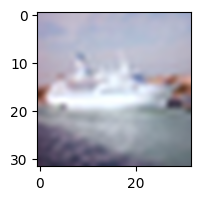

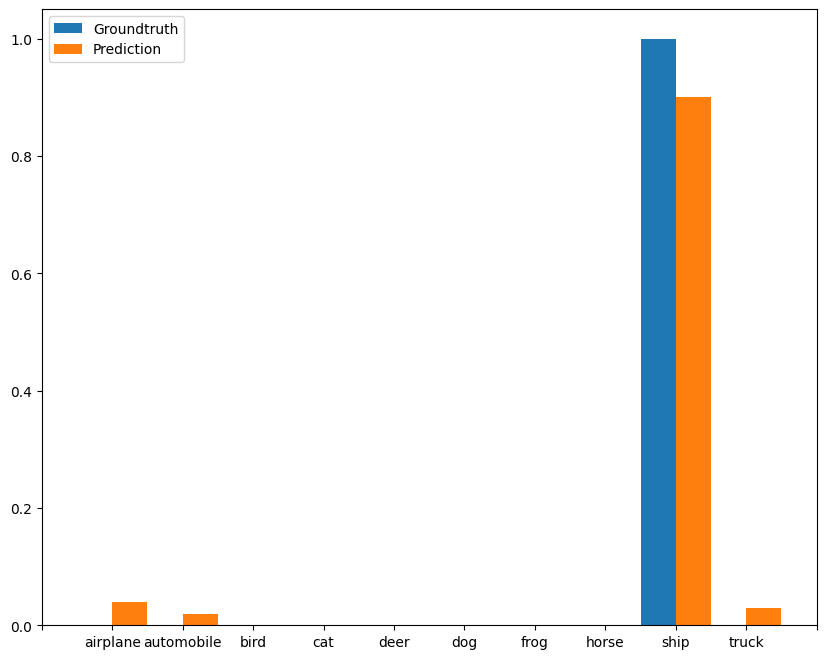

In [20]:
img_idx = 1111

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def show_prediction(image_idx):
    img = np.clip((np.transpose(data['X_test'][image_idx], [1,2,0])/255)+0.5,0,1)
    scores = np.transpose(pred['scores'])
    scores = np.round(softmax(scores[image_idx]),2)
    gt = np.zeros(10)
    gt[data['y_test'][image_idx]]=1

    plt.figure(figsize = (2,2))
    plt.imshow(img, interpolation='lanczos')
    names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    x_axis = np.arange(len(names))

    fig, ax = plt.subplots(figsize=(10,8))
    width = 0.5 
    rects1 = ax.bar(x_axis-width/2, gt, 0.5, label='Groundtruth')
    rects1 = ax.bar(x_axis+width/2, scores, 0.5, label='Prediction')
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_xticklabels(['']+names+[''])
    plt.legend()
    plt.show()
    return None

show_prediction(img_idx)

# 3. Qualitative Analysis of Predictions
<a id="qualitative_analysis"></a>

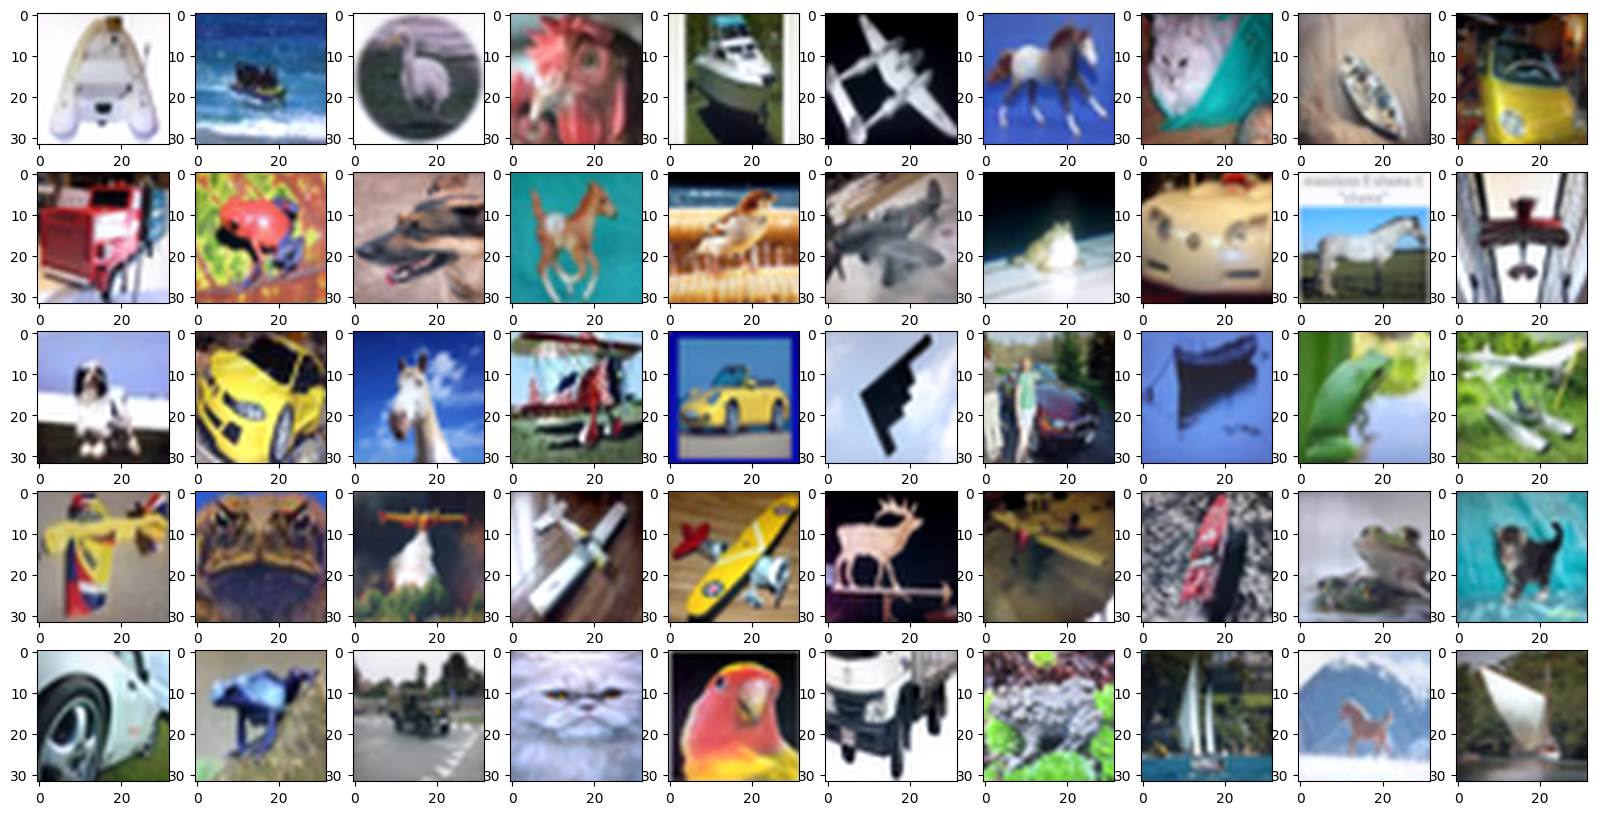

In [21]:
def prediction_diff(image_idx):
    scores = np.transpose(pred['scores'])
    scores = np.round(softmax(scores[image_idx]),2)
    return 1 - scores[data['y_test'][image_idx]]

differences = np.zeros(10000)
for i in range(10000):
    differences[i] = prediction_diff(i)

worst = np.argpartition(differences, -50)[-50:]
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)  
    img = np.clip((np.transpose(data['X_test'][worst[i]], [1,2,0])/255)+0.5,0,1)
    plt.imshow(img, interpolation='lanczos')

plt.show()

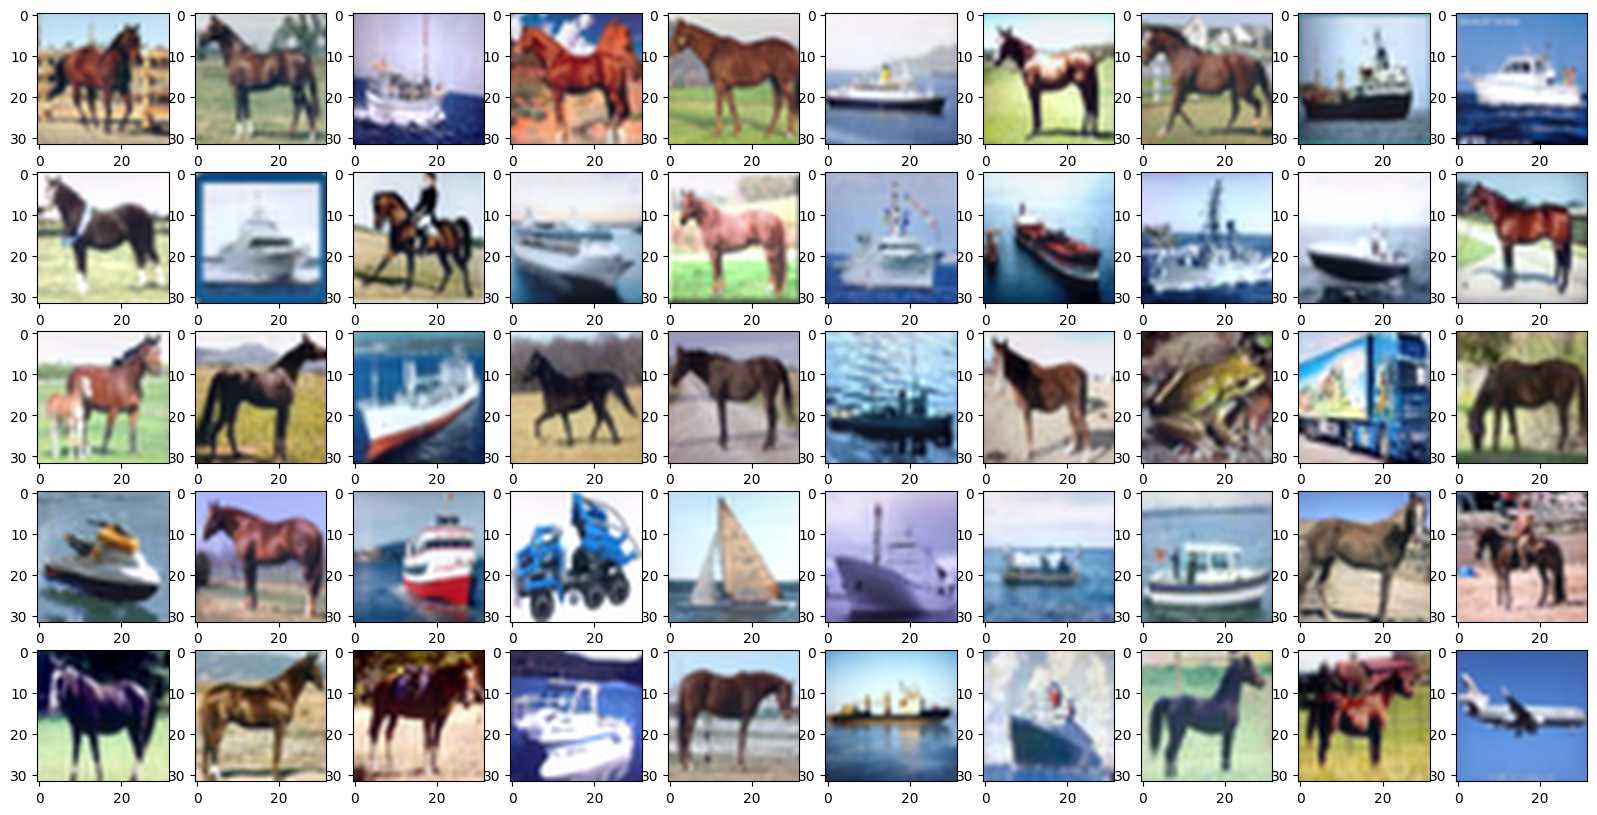

In [22]:
best = np.argpartition(differences, 50)[:50]
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)  
    img = np.clip((np.transpose(data['X_test'][best[i]], [1,2,0])/255)+0.5,0,1)
    plt.imshow(img, interpolation='lanczos')

plt.show()

In [ ]:
for i in worst:
    show_prediction(i)

In [ ]:
for i in best:
    show_prediction(i)

<a id="qualitative_analysis_questions"></a>
## 3.1 Qualitative Analysis of Predictions - Questions
Once again, (1) analyze the predictions of your model. Do the false predictions share certain properties the true predictions don't exhibit? (2) You heard a lot about modifications for CNNs in the cs231n lecture. Describe and justify 3 modifications for CNNs, which could help to improve your model.

(1) Your answere here

Similar to the last exercise. The false predictions often have weird backgrounds like borders,
artificial colors (where the subject was cropped out and placed on a new background) and backgrounds where the ground is not visible/discernible. 

(2) Your answere here

1. Use dropout to prevent overfitting on the training data.
2. Use data augmentation to create new samples that can help the model to generalize better.
3. Use a form of normalization which could help with generalization as well.

